# Imports & Functions

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score



from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from livelossplot import PlotLossesKerasTF
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler


#######################################################################################################################################
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import logging

import tensorflow as tf

import sklearn
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)

os.environ['CUDA_VISIBLE_DEVICES'] =  ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] =  ''

os.environ['XLA_FLAGS'] = ''#-10.1' #--xla_gpu_cuda_data_dir=/usr/local/cuda, 
os.environ['TF_XLA_FLAGS'] = ''#'--tf_xla_auto_jit=2' #, --tf_xla_enable_xla_devices



In [2]:
import numpy as np
from collections import deque
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import _tree as ctree
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


class AABB:
    """Axis-aligned bounding box"""
    def __init__(self, n_features):
        self.limits = np.array([[-np.inf, np.inf]] * n_features)

    def split(self, f, v):
        left = AABB(self.limits.shape[0])
        right = AABB(self.limits.shape[0])
        left.limits = self.limits.copy()
        right.limits = self.limits.copy()

        left.limits[f, 1] = v
        right.limits[f, 0] = v

        return left, right


def tree_bounds(tree, n_features=None):
    """Compute final decision rule for each node in tree"""
    if n_features is None:
        n_features = np.max(tree.feature) + 1
    aabbs = [AABB(n_features) for _ in range(tree.node_count)]
    queue = deque([0])
    while queue:
        i = queue.pop()
        l = tree.children_left[i]
        r = tree.children_right[i]
        if l != ctree.TREE_LEAF:
            aabbs[l], aabbs[r] = aabbs[i].split(tree.feature[i], tree.threshold[i])
            queue.extend([l, r])
    return aabbs


def decision_areas(tree_classifier, maxrange, x=0, y=1, n_features=None):
    """ Extract decision areas.

    tree_classifier: Instance of a sklearn.tree.DecisionTreeClassifier
    maxrange: values to insert for [left, right, top, bottom] if the interval is open (+/-inf) 
    x: index of the feature that goes on the x axis
    y: index of the feature that goes on the y axis
    n_features: override autodetection of number of features
    """
    tree = tree_classifier.tree_
    aabbs = tree_bounds(tree, n_features)

    rectangles = []
    for i in range(len(aabbs)):
        if tree.children_left[i] != ctree.TREE_LEAF:
            continue
        l = aabbs[i].limits
        r = [l[x, 0], l[x, 1], l[y, 0], l[y, 1], np.argmax(tree.value[i])]
        rectangles.append(r)
    rectangles = np.array(rectangles)
    rectangles[:, [0, 2]] = np.maximum(rectangles[:, [0, 2]], maxrange[0::2])
    rectangles[:, [1, 3]] = np.minimum(rectangles[:, [1, 3]], maxrange[1::2])
    return rectangles

def plot_areas(rectangles):
    for rect in rectangles:
        color = ['b', 'r'][int(rect[4])]
        print(rect[0], rect[1], rect[2] - rect[0], rect[3] - rect[1])
        rp = Rectangle([rect[0], rect[2]], 
                       rect[1] - rect[0], 
                       rect[3] - rect[2], color=color, alpha=0.3)
        plt.gca().add_artist(rp)

# Distribution Specifications

In [3]:
## good example for gamma

flip = np.random.randint(0,2)
print(flip)
if flip == 0:
    param_0_d1 = 1#np.random.uniform(0, 0.5)#np.random.uniform(min_param_1, max_param_1)
    param_0_d2 = 2#np.random.uniform(1.5, 2)#np.random.uniform(min_param_1, max_param_1)

    param_1_d1 = 1#np.random.uniform(0, 0.5)#np.random.uniform(min_param_2, max_param_2)
    param_1_d2 = 5#np.random.uniform(1.5, 2)#np.random.uniform(min_param_2, max_param_2)
else:
    param_0_d1 = 2#np.random.uniform(1.5, 2)#np.random.uniform(min_param_1, max_param_1)
    param_0_d2 = 1#np.random.uniform(0, 0.5)#np.random.uniform(min_param_1, max_param_1)

    param_1_d1 = 5#np.random.uniform(1.5, 2)#np.random.uniform(min_param_2, max_param_2)
    param_1_d2 = 1#np.random.uniform(0, 0.5)#np.random.uniform(min_param_2, max_param_2)  

1


## joint distributions
    gaussian mixtures and Dirichlet distribution for multidimensional

    multivariate normal distribution
    multivariate stable distribution
    multinomial distribution
    negative multinomial distribution
    multivariate hypergeometric distribution
    elliptical distribution.
    
    https://en.wikipedia.org/wiki/List_of_probability_distributions#Joint_distributions

## BETA WORKING EXAMPLE
    beta, seed=5, no_flip

    Feature 1:
    Distribution 1: 0.44398634217947897 0.41343831067885284
    Distribution 2: 1.7414646123547528 1.837221815875843
    Feature 2:
    Distribution 1: 1.7857203028720032 1.6424582461156636
    Distribution 2: 0.6639596106023544 0.0833932514504998

    class0_data_feature = class0_data_feature + 0.2

In [4]:
## GAMMA WORKING EXAMPLE

D = 2
N = 5000
seed = 8

depth = 3

min_param_1 = 0
max_param_1 = 2

min_param_2 = 0
max_param_2 = 5

distribution_name = 'gamma'

distrib_param_list = []

if True:
    data_list = []

    for i in range(D):
        np.random.seed(seed+i)

        flip = np.random.randint(0,1)
        print(flip)
        if flip == 0:
            param_0_d1 = np.random.uniform(min_param_1, max_param_1)#np.random.uniform(0, 0.5)#np.random.uniform(min_param_1, max_param_1)
            param_0_d2 = np.random.uniform(min_param_1, max_param_1)#np.random.uniform(1.5, 2)#np.random.uniform(min_param_1, max_param_1)

            param_1_d1 = np.random.uniform(min_param_2, max_param_2)#np.random.uniform(0, 0.5)#np.random.uniform(min_param_2, max_param_2)
            param_1_d2 = np.random.uniform(min_param_2, max_param_2)#np.random.uniform(1.5, 2)#np.random.uniform(min_param_2, max_param_2)
        else:
            param_0_d1 = np.random.uniform(min_param_1, max_param_1)#1#np.random.uniform(1.5, 2)#np.random.uniform(min_param_1, max_param_1)
            param_0_d2 = np.random.uniform(min_param_1, max_param_1)#5#np.random.uniform(0, 0.5)#np.random.uniform(min_param_1, max_param_1)

            param_1_d1 = np.random.uniform(min_param_2, max_param_2)#5#np.random.uniform(1.5, 2)#np.random.uniform(min_param_2, max_param_2)
            param_1_d2 = np.random.uniform(min_param_2, max_param_2)#1#np.random.uniform(0, 0.5)#np.random.uniform(min_param_2, max_param_2)  

0
0


In [5]:
            
#Feature 1:
#Distribution 1: 1.7468588055836325 4.345972701069599
#Distribution 2: 1.937081325641864 2.6542784577779948
#Feature 2:
#Distribution 1: 0.02074830777139991 2.4788664656707304
#Distribution 2: 1.0037491842974775 0.6691476447963829

## gamma working example 2

    min_param_1_class0 = 0#2
    max_param_1_class0 = 0.5#2

    min_param_2_class0 = 2#4
    max_param_2_class0 = 3#4


    min_param_1_class1 = 0.5#2
    max_param_1_class1 = 1.5#2

    min_param_2_class1 = 0.5#2.5
    max_param_2_class1 = 1#2.5

    distribution_name = 'gamma'

    distrib_param_list = []

    if True:
        data_list = []

        for i in range(D):
            np.random.seed(seed+i)

            flip = np.random.randint(0,1)
            print(flip)
            #if flip == 0:
            if True:
            #if i == 0:
                param_0_d1 = np.random.uniform(min_param_1_class0, max_param_1_class0)#np.random.uniform(0, 0.5)#np.random.uniform(min_param_1, max_param_1)
                param_0_d2 = np.random.uniform(min_param_1_class1, max_param_1_class1)#np.random.uniform(1.5, 2)#np.random.uniform(min_param_1, max_param_1)

                param_1_d1 = np.random.uniform(min_param_2_class0, max_param_2_class0)#np.random.uniform(0, 0.5)#np.random.uniform(min_param_2, max_param_2)
                param_1_d2 = np.random.uniform(min_param_2_class1, max_param_2_class1)#np.random.uniform(1.5, 2)#np.random.uniform(min_param_2, max_param_2)
            else:
                param_0_d1 = 1.74#np.random.uniform(min_param_1, max_param_1)#1#np.random.uniform(1.5, 2)#np.random.uniform(min_param_1, max_param_1)
                param_0_d2 = 1.93#np.random.uniform(min_param_1, max_param_1)#5#np.random.uniform(0, 0.5)#np.random.uniform(min_param_1, max_param_1)

                param_1_d1 = 4.34#np.random.uniform(min_param_2, max_param_2)#5#np.random.uniform(1.5, 2)#np.random.uniform(min_param_2, max_param_2)
                param_1_d2 = 2.65#np.random.uniform(min_param_2, max_param_2)#1#np.random.uniform(0, 0.5)#np.random.uniform(min_param_2, max_param_2)            

    Feature 1:
    Distribution 1: 0.0901348444383846 2.463218526498345
    Distribution 2: 0.5194752414876246 0.8624669645960739
    Feature 2:
    Distribution 1: 0.07708142118983619 2.2633150151851344
    Distribution 2: 1.2400496965154049 0.7668696966901489

## UNIFORM WORKING

        if i == 0:
            param_0_d1 = 0#np.random.uniform(min_param_1_class0, max_param_1_class0)#np.random.uniform(0, 0.5)#np.random.uniform(min_param_1, max_param_1)
            param_0_d2 = 2#np.random.uniform(min_param_1_class1, max_param_1_class1)#np.random.uniform(1.5, 2)#np.random.uniform(min_param_1, max_param_1)

            param_1_d1 = 20#np.random.uniform(min_param_2_class0, max_param_2_class0)#np.random.uniform(0, 0.5)#np.random.uniform(min_param_2, max_param_2)
            param_1_d2 = 8#np.random.uniform(min_param_2_class1, max_param_2_class1)#np.random.uniform(1.5, 2)#np.random.uniform(min_param_2, max_param_2)
        else:
            param_0_d1 = 3#np.random.uniform(min_param_1, max_param_1)#1#np.random.uniform(1.5, 2)#np.random.uniform(min_param_1, max_param_1)
            param_0_d2 = -6#np.random.uniform(min_param_1, max_param_1)#5#np.random.uniform(0, 0.5)#np.random.uniform(min_param_1, max_param_1)

            param_1_d1 = 4#np.random.uniform(min_param_2, max_param_2)#5#np.random.uniform(1.5, 2)#np.random.uniform(min_param_2, max_param_2)
            param_1_d2 = 6#np.random.uniform(min_param_2, max_param_2)#1#np.random.uniform(0, 0.5)#np.random.uniform(min_param_2, max_param_2)  

## beta working

    min_param_1_class0 = 0#2
    max_param_1_class0 = 0.5#2

    min_param_2_class0 = 1#4
    max_param_2_class0 = 2#4


    min_param_1_class1 = 0.5#2
    max_param_1_class1 = 1.5#2

    min_param_2_class1 = 5#2.5
    max_param_2_class1 = 10#2.5
    
    Feature 1:
    Distribution 1: 0.0901348444383846 1.4632185264983446
    Distribution 2: 0.5194752414876246 8.62466964596074
    Feature 2:
    Distribution 1: 0.07708142118983619 1.2633150151851347
    Distribution 2: 1.2400496965154049 7.668696966901489

# Experiments

In [6]:
D = 2
N = 5000
seed = 12

depth = 3

In [7]:
#class0_data = np.random.normal(0,1, (N, D))
#class1_data = np.random.normal(1,1, (N, D)) 

min_param_1_class0 = 0#0
max_param_1_class0 = 2#1

min_param_2_class0 = 0#0
max_param_2_class0 = 3#1


min_param_1_class1 = 1#0.2
max_param_1_class1 = 3#0.2

min_param_2_class1 = 0#0.5
max_param_2_class1 = 3#0.5

distribution_name = 'normal'

distrib_param_list = []

if True:
    data_list = []

    for i in range(D):
        np.random.seed(seed+i)
        
        flip = np.random.randint(0,2)
        print(flip)
        #if flip == 0:
        if False:
            param_0_d1 = np.random.uniform(min_param_1_class0, max_param_1_class0)#np.random.uniform(0, 0.5)#np.random.uniform(min_param_1, max_param_1)
            param_0_d2 = np.random.uniform(min_param_1_class1, max_param_1_class1)#np.random.uniform(1.5, 2)#np.random.uniform(min_param_1, max_param_1)

            param_1_d1 = np.random.uniform(min_param_2_class0, max_param_2_class0)#np.random.uniform(0, 0.5)#np.random.uniform(min_param_2, max_param_2)
            param_1_d2 = np.random.uniform(min_param_2_class1, max_param_2_class1)#np.random.uniform(0, 0.5) if param_1_d1 > 1.5 else np.random.uniform(2.5, 3)#np.random.uniform(min_param_2_class1, max_param_2_class1)#np.random.uniform(1.5, 2)#np.random.uniform(min_param_2, max_param_2)        
        elif i == 0:
            if distribution_name == 'normal':
                param_0_d1 = 0
                param_1_d1 = 0.7
                
                param_0_d2 = 3
                param_1_d2 = 2.5#1.5
            elif distribution_name == 'uniform':
                param_0_d1 = 1.5#0
                param_1_d1 = 6.5#20
                
                param_0_d2 = 2#2
                param_1_d2 = 3.5#8   
            elif distribution_name == 'gamma':     
                param_0_d1 = 1
                param_1_d1 = 1
                
                param_0_d2 = 2
                param_1_d2 = 5           
        else:
            if distribution_name == 'normal':
                param_0_d1 = 3
                param_1_d1 = 7#5
                
                param_0_d2 = 0
                param_1_d2 = 0.5#0.5      
            elif distribution_name == 'uniform':
                param_0_d1 = 2.25#3
                param_1_d1 = 2.5#4
                
                param_0_d2 = 0#-6
                param_1_d2 = 3#6  
            elif distribution_name == 'gamma':
                param_0_d1 = 2
                param_1_d1 = 5
                
                param_0_d2 = 1
                param_1_d2 = 1  
                
        if distribution_name == 'normal':
            class0_data_feature = np.random.normal(loc=param_0_d1, scale=param_1_d1, size=N)
            class1_data_feature = np.random.normal(loc=param_0_d2, scale=param_1_d2, size=N)
        elif distribution_name == 'uniform':
            class0_data_feature = np.random.uniform(low=min(param_0_d1, param_1_d1), high=max(param_0_d1, param_1_d1), size=N)
            class1_data_feature = np.random.uniform(low=min(param_0_d2, param_1_d2), high=max(param_0_d2, param_1_d2), size=N)                    
        elif distribution_name == 'gamma':  
            class0_data_feature = np.random.gamma(shape=param_0_d1, scale=param_1_d1, size=N) #shape: The shape of the gamma distribution. Must be non-negative. 
            class1_data_feature = np.random.gamma(shape=param_0_d2, scale=param_1_d2, size=N) #scale: The scale of the gamma distribution. Must be non-negative. Default is equal to 1.
        elif distribution_name == 'exponential':  #special case of gamma   
            class0_data_feature = np.random.exponential(scale=param_0_d1, size=N) #The scale parameter. Must be non-negative.
            class1_data_feature = np.random.exponential(scale=param_0_d2, size=N)              
        elif distribution_name == 'beta':
            class0_data_feature = np.random.beta(a=param_0_d1, b=param_1_d1, size=N)
            class1_data_feature = np.random.beta(a=param_0_d2, b=param_1_d2, size=N)                
        elif distribution_name == 'binomial':   
            class0_data_feature = np.random.binomial(n=10, p=param_1_d1, size=N)
            class1_data_feature = np.random.binomial(n=10, p=param_1_d2, size=N)               
        elif distribution_name == 'poisson':
            class0_data_feature = np.random.poisson(lam=param_0_d1, size=N)
            class1_data_feature = np.random.poisson(lam=param_0_d2, size=N)
            
        #class0_data_feature = class0_data_feature + 0.2
                    
        data_feature = np.hstack([class0_data_feature, class1_data_feature])

        data_list.append(data_feature)
        distrib_param_list.append([param_0_d1, param_1_d1, param_0_d2, param_1_d2])
        
    X_data = np.hstack([data_list]).T.astype(np.float64)
    y_data = np.hstack([[0]*N, [1]*N]).reshape(-1,1).astype(np.int64)
    
else:
    if True:
        #class0_data = np.random.multivariate_normal(mean=[0,1], cov=[[0,10], [2,10]], size=(N))
        #class1_data = np.random.multivariate_normal(mean=[1,0], cov=[[0,1], [30,1]], size=(N))
        
        class0_data = np.random.multivariate_normal(mean=[np.random.uniform(0,1),np.random.uniform(0,1)], cov=[[np.random.uniform(0,50),np.random.uniform(0,50)], [np.random.uniform(0,50),np.random.uniform(0,50)]], size=(N))
        class1_data = np.random.multivariate_normal(mean=[np.random.uniform(0,1),np.random.uniform(0,1)], cov=[[np.random.uniform(0,50),np.random.uniform(0,50)], [np.random.uniform(0,50),np.random.uniform(0,50)]], size=(N))
    elif False:
        class0_data = np.random.dirichlet(alpha=[3,2], size=(N))
        class1_data = np.random.dirichlet(alpha=[5,7], size=(N))        
    
    X_data = np.vstack([class0_data, class1_data])
    
    y_data = np.hstack([[0]*N, [1]*N]).reshape(-1,1).astype(np.int64)    
            

    
for i, column in enumerate(X_data.T):
    scaler = MinMaxScaler()
    scaler.fit(column.reshape(-1, 1))
    X_data[:,i] = scaler.transform(column.reshape(-1, 1)).ravel()
    
data = np.hstack([X_data, y_data])

columns = ['feature_' + str(i) for i in range(D)]
columns.append('class')

try:
    print('Feature 1:')
    print('Distribution 1:', distrib_param_list[0][0], distrib_param_list[0][1])
    print('Distribution 2:', distrib_param_list[0][2], distrib_param_list[0][3])
    print('Feature 2:')
    print('Distribution 1:', distrib_param_list[1][0], distrib_param_list[1][1])
    print('Distribution 2:', distrib_param_list[1][2], distrib_param_list[1][3])
except:
    pass
    
df = pd.DataFrame(data=data, columns=columns)
df.head()

1
0
Feature 1:
Distribution 1: 0 0.7
Distribution 2: 3 2.5
Feature 2:
Distribution 1: 3 7
Distribution 2: 0 0.5


,feature_0,feature_1,class
0,0.376147,0.673018,0.0
1,0.327618,0.565993,0.0
2,0.343256,0.638762,0.0
3,0.316103,0.642017,0.0
4,0.322491,0.711414,0.0


<AxesSubplot:xlabel='feature_0', ylabel='feature_1'>

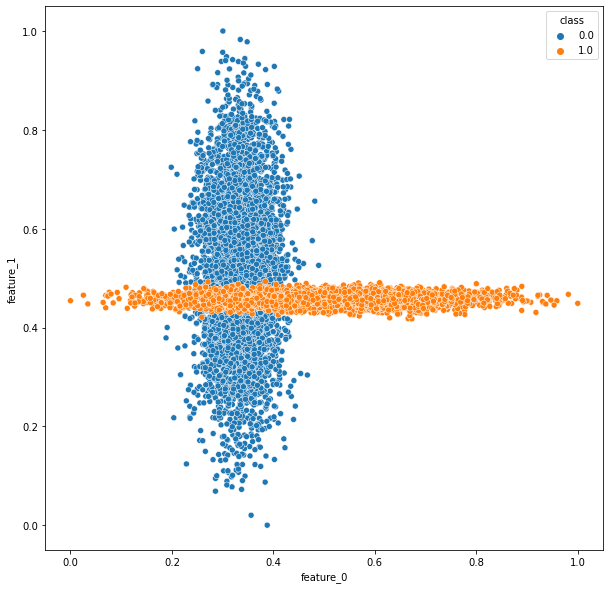

In [8]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df, x="feature_0", y="feature_1", hue='class')

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X_data, y_data, test_size=0.2, random_state=seed)

In [10]:
if False:
    tree = DecisionTreeClassifier(max_depth=depth)

    tree.fit(X_train[:,:2], y_train)

    y_valid_pred = tree.predict(X_valid[:,:2])
    print('Accuracy 2 Features', accuracy_score(y_valid, y_valid_pred))

    try:
        plt.figure(figsize=(15, 15))
        plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

        rectangles = decision_areas(tree, [0, 1, 0, 1])
        plot_areas(rectangles)
        plt.xlim(0, 1)
        plt.ylim(0, 1)
    except:
        pass

In [11]:
if False:
    tree = DecisionTreeClassifier(max_depth=depth)

    tree.fit(X_train, y_train)

    feature_index = list(np.sort(np.argsort(tree.feature_importances_)[::-1][:2]))

    y_valid_pred = tree.predict(X_valid)
    print('Accuracy All Features', accuracy_score(y_valid, y_valid_pred))

    try:
        plt.figure(figsize=(15, 15))
        plt.scatter(X_train[:, feature_index[0]], X_train[:, feature_index[1]], c=y_train)

        rectangles = decision_areas(tree, [0, 1, 0, 1])
        plot_areas(rectangles)
        plt.xlim(0, 1)
        plt.ylim(0, 1)
    except:
        pass

In [12]:
np.random.seed(seed)
tf.random.set_seed(seed)

model = Sequential()

model.add(Dense(128, activation='relu', input_dim=D, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed), bias_initializer='zeros'))
#model.add(Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed), bias_initializer='zeros'))

model.add(Dense(1, 
                activation='sigmoid', 
                kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed), 
                bias_initializer='zeros'))


optimizer = tf.keras.optimizers.get('adam')
optimizer.learning_rate = 0.001

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',#tf.keras.losses.get(config['lambda_net']['loss_lambda']),
              metrics=[tf.keras.metrics.get("binary_accuracy")]
             )

model.fit(X_train, 
          y_train,
          batch_size=64,
          epochs=100,
          #callbacks=[PlotLossesKerasTF()]
         )

y_valid_pred = np.round(model.predict(X_valid)).astype(np.int64)
print('Accuracy All Features', accuracy_score(y_valid, y_valid_pred))


Epoch 1/100
125/125 [==============================] - 0s 604us/step - loss: 0.6419 - binary_accuracy: 0.7614
Epoch 2/100
125/125 [==============================] - 0s 587us/step - loss: 0.5488 - binary_accuracy: 0.8224
Epoch 3/100
125/125 [==============================] - 0s 579us/step - loss: 0.4646 - binary_accuracy: 0.8295
Epoch 4/100
125/125 [==============================] - 0s 578us/step - loss: 0.4141 - binary_accuracy: 0.8379
Epoch 5/100
125/125 [==============================] - 0s 579us/step - loss: 0.3846 - binary_accuracy: 0.8444
Epoch 6/100
125/125 [==============================] - 0s 582us/step - loss: 0.3641 - binary_accuracy: 0.8530
Epoch 7/100
125/125 [==============================] - 0s 614us/step - loss: 0.3478 - binary_accuracy: 0.8610
Epoch 8/100
125/125 [==============================] - 0s 595us/step - loss: 0.3343 - binary_accuracy: 0.8677
Epoch 9/100
125/125 [==============================] - 0s 577us/step - loss: 0.3223 - binary_accuracy: 0.8700
Epoch 10/1

Accuracy  NN 0.9285
Fidelity Train Data DT 0.9385
Fidelity Random Data DT 0.718


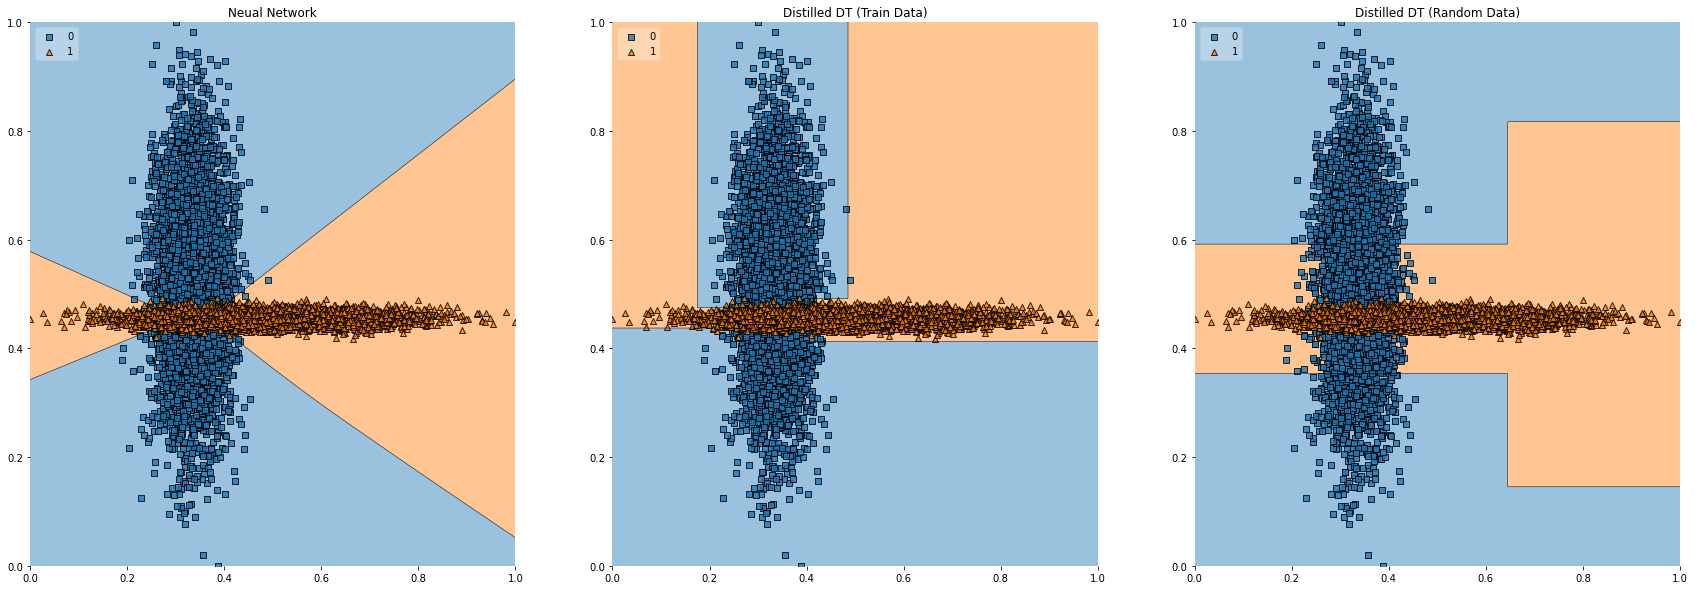

In [13]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec

tree_train_data = DecisionTreeClassifier(max_depth=depth)

y_train_network = np.round(model.predict(X_train)).astype(np.int64)

tree_train_data.fit(X_train, y_train_network)

y_valid_pred_tree_train_data = tree_train_data.predict(X_valid)
y_valid_pred_network = np.round(model.predict(X_valid)).astype(np.int64)


feature_index = list(np.sort(np.argsort(tree_train_data.feature_importances_)[::-1][:2]))
filler_features = list(np.sort(np.argsort(tree_train_data.feature_importances_)[::-1][2:]))

tree_random_data = DecisionTreeClassifier(max_depth=depth)

np.random.seed(seed)
random_data = np.random.uniform(0,1, (y_train.shape[0],D))
#random_data = np.random.normal(0,1, (y_train.shape[0],D))
#random_data = np.random.beta(1,1, (y_train.shape[0],D))

for i, column in enumerate(random_data.T):
    scaler = MinMaxScaler()
    scaler.fit(column.reshape(-1, 1))
    random_data[:,i] = scaler.transform(column.reshape(-1, 1)).ravel()

random_data_labels = np.round(model.predict(random_data)).astype(np.int64)

tree_random_data.fit(random_data, random_data_labels)

y_valid_pred_tree_random_data = tree_random_data.predict(X_valid)
y_valid_pred_network = np.round(model.predict(X_valid)).astype(np.int64)

print('Accuracy  NN', accuracy_score(y_valid, y_valid_pred_network))
print('Fidelity Train Data DT', accuracy_score(y_valid_pred_network, y_valid_pred_tree_train_data))
print('Fidelity Random Data DT', accuracy_score(y_valid_pred_network, y_valid_pred_tree_random_data))

#plot_decision_regions(X=X_train, y=y_train.ravel(), clf=model, legend=2)

value=0.5
width=0.5

filler_feature_values = {}
filler_feature_ranges = {}
for feature in filler_features:
    filler_feature_values[feature] = value
    filler_feature_ranges[feature] = width

    
#gs = gridspec.GridSpec(2, 2)
gs = gridspec.GridSpec(1, 4)

fig = plt.figure(figsize=(40,10))

labels = ['Neual Network', 'Distilled DT (Train Data)', 'Distilled DT (Random Data)'] #'Distilled DT (I-Net)'
for i, (clf, lab) in enumerate(zip([model, tree_train_data, tree_random_data],
                         labels)):

    #ax = plt.subplot(gs[i//2, i%2])
    ax = plt.subplot(gs[i])
    fig = plot_decision_regions(X=X_train,
                      y=y_train.ravel(), 
                      clf=clf,
                      feature_index=feature_index,#[0,1],                        #these one will be plotted  
                      filler_feature_values=filler_feature_values,#{2: value, 3:value},  #these will be ignored
                      filler_feature_ranges=filler_feature_ranges,#{2: width, 3: width}, 
                      legend=2)
    plt.title(lab)
    plt.xlim([0, 1])
    plt.ylim([0, 1])

    
#plt.xlim([0, 1])
#plt.ylim([0, 1])
#plt.xlabel("x", size=5)
#plt.ylabel("y", size=5)
#plt.title('Plot Decision Region Boundary', size=10)
plt.show()

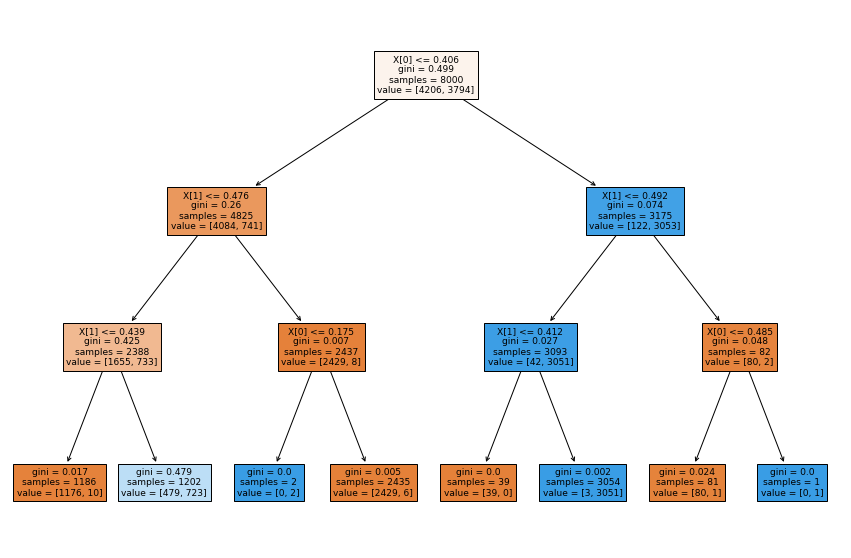

In [14]:
plt.figure(figsize=(15, 10))
plot_tree(tree_train_data, filled=True)
plt.show()

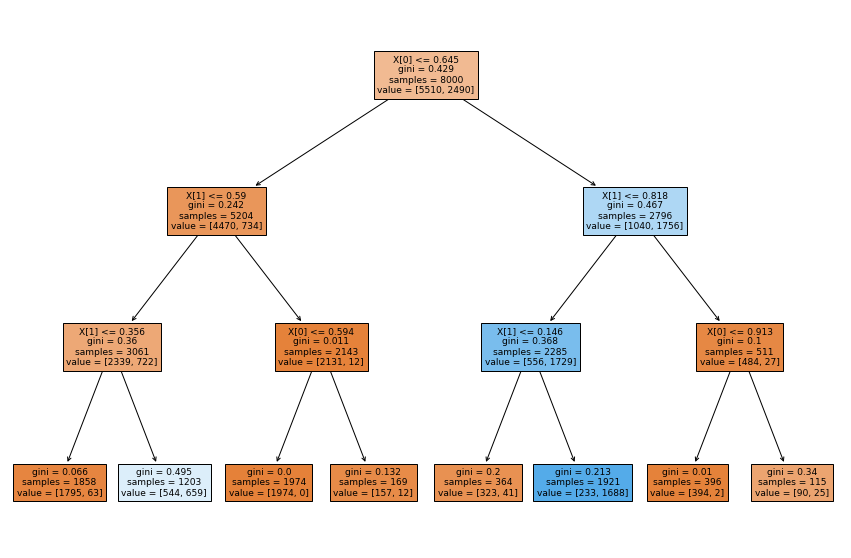

In [15]:
plt.figure(figsize=(15, 10))
plot_tree(tree_random_data, filled=True)
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy  NN 0.9285
Fidelity Train Data DT 0.665
Fidelity Random Data DT 0.518


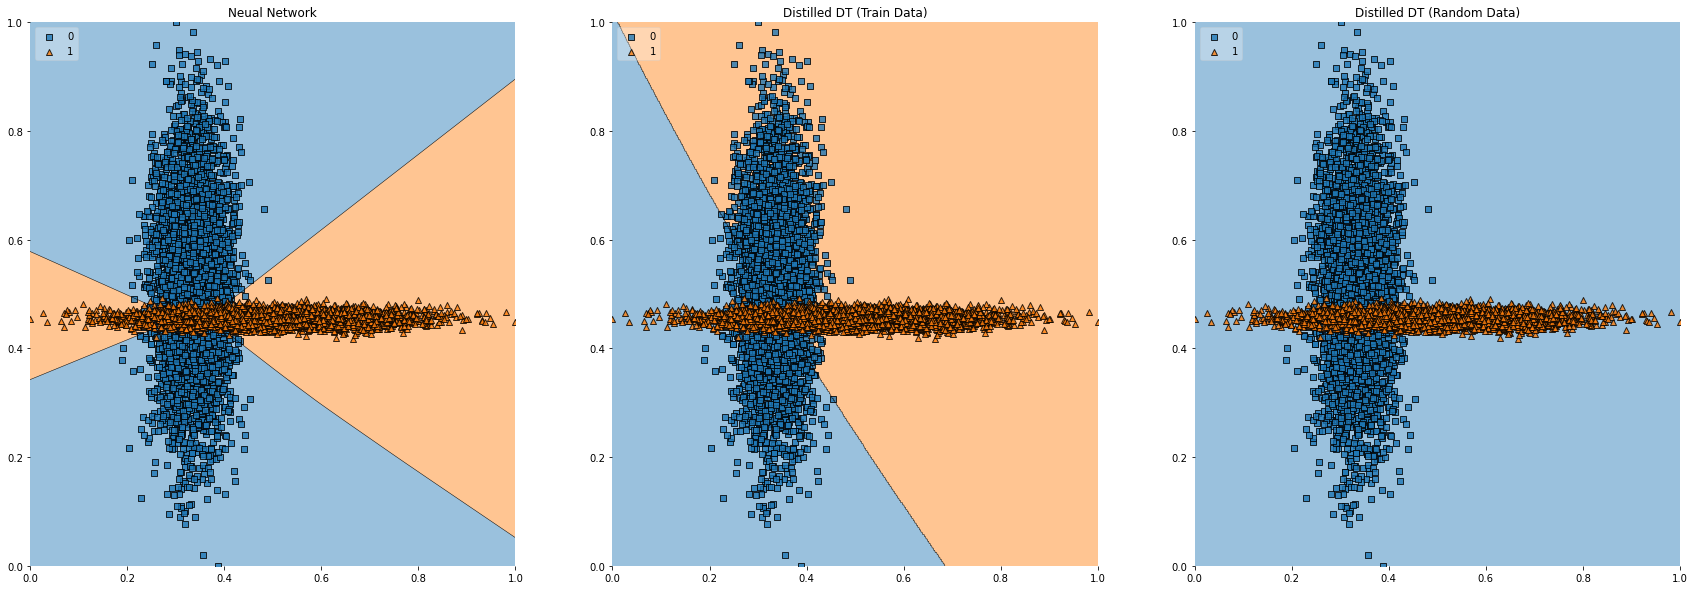

In [16]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
from utilities.DecisionTree_BASIC import *

tree_train_data = SDT(input_dim=X_train.shape[1],#X_train.shape[1], 
                       output_dim=2,#int(max(y_train))+1, 
                       depth=depth,
                       #beta=0,
                       decision_sparsity=1,
                       random_seed=seed,
                       use_cuda=False,
                       verbosity=1)

y_train_network = np.round(model.predict(X_train)).astype(np.int64)

tree_train_data.fit(X_train, y_train_network, epochs=50)

y_valid_pred_tree_train_data = tree_train_data.predict(X_valid)
y_valid_pred_network = np.round(model.predict(X_valid)).astype(np.int64)


#feature_index = list(np.sort(np.argsort(tree_train_data.feature_importances_)[::-1][:2]))
#filler_features = list(np.sort(np.argsort(tree_train_data.feature_importances_)[::-1][2:]))

tree_random_data = SDT(input_dim=X_train.shape[1],#X_train.shape[1], 
                       output_dim=2,#int(max(y_train))+1, 
                       depth=depth,
                       #beta=0,
                       decision_sparsity=1,
                       random_seed=seed,
                       use_cuda=False,
                       verbosity=1)

np.random.seed(seed)
random_data = np.random.uniform(0,1, (y_train.shape[0],D))
#random_data = np.random.normal(0,1, (y_train.shape[0],D))
#random_data = np.random.beta(1,1, (y_train.shape[0],D))

for i, column in enumerate(random_data.T):
    scaler = MinMaxScaler()
    scaler.fit(column.reshape(-1, 1))
    random_data[:,i] = scaler.transform(column.reshape(-1, 1)).ravel()

random_data_labels = np.round(model.predict(random_data)).astype(np.int64)

tree_random_data.fit(random_data, random_data_labels, epochs=50)

y_valid_pred_tree_random_data = tree_random_data.predict(X_valid)
y_valid_pred_network = np.round(model.predict(X_valid)).astype(np.int64)

print('Accuracy  NN', accuracy_score(y_valid, y_valid_pred_network))
print('Fidelity Train Data DT', accuracy_score(y_valid_pred_network, y_valid_pred_tree_train_data))
print('Fidelity Random Data DT', accuracy_score(y_valid_pred_network, y_valid_pred_tree_random_data))

#plot_decision_regions(X=X_train, y=y_train.ravel(), clf=model, legend=2)

value=0.5
width=0.5

filler_feature_values = {}
filler_feature_ranges = {}
for feature in filler_features:
    filler_feature_values[feature] = value
    filler_feature_ranges[feature] = width

    
#gs = gridspec.GridSpec(2, 2)
gs = gridspec.GridSpec(1, 4)

fig = plt.figure(figsize=(40,10))

labels = ['Neual Network', 'Distilled DT (Train Data)', 'Distilled DT (Random Data)'] #'Distilled DT (I-Net)'
for i, (clf, lab) in enumerate(zip([model, tree_train_data, tree_random_data],
                         labels)):

    #ax = plt.subplot(gs[i//2, i%2])
    ax = plt.subplot(gs[i])
    fig = plot_decision_regions(X=X_train,
                      y=y_train.ravel(), 
                      clf=clf,
                      feature_index=feature_index,#[0,1],                        #these one will be plotted  
                      filler_feature_values=filler_feature_values,#{2: value, 3:value},  #these will be ignored
                      filler_feature_ranges=filler_feature_ranges,#{2: width, 3: width}, 
                      legend=2)
    plt.title(lab)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    
#plt.xlim([0, 1])
#plt.ylim([0, 1])
#plt.xlabel("x", size=5)
#plt.ylabel("y", size=5)
#plt.title('Plot Decision Region Boundary', size=10)
plt.show()

In [17]:
#tree_train_data.plot_tree()

In [18]:
#tree_random_data.plot_tree()

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy  NN 0.9285
Fidelity Train Data DT 0.941
Fidelity Random Data DT 0.927


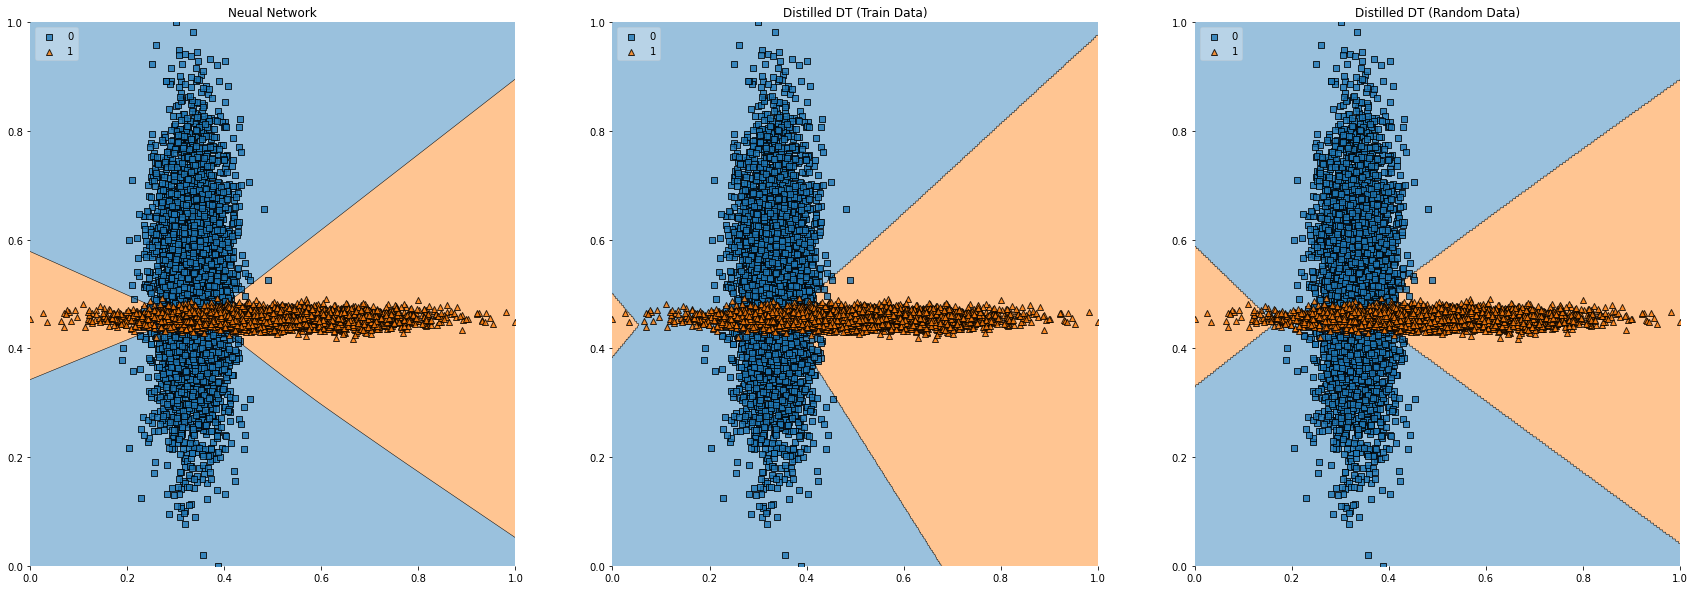

In [19]:
from mlxtend.plotting import plot_decision_regions
from utilities.DecisionTree_BASIC import *

tree_train_data = SDT(input_dim=X_train.shape[1],#X_train.shape[1], 
                       output_dim=2,#int(max(y_train))+1, 
                       depth=depth,
                       #beta=0,
                       decision_sparsity=-1,
                       random_seed=seed,
                       use_cuda=False,
                       verbosity=1)

y_train_network = np.round(model.predict(X_train)).astype(np.int64)

tree_train_data.fit(X_train, y_train_network, epochs=50)

y_valid_pred_tree_train_data = tree_train_data.predict(X_valid)
y_valid_pred_network = np.round(model.predict(X_valid)).astype(np.int64)


#feature_index = list(np.sort(np.argsort(tree_train_data.feature_importances_)[::-1][:2]))
#filler_features = list(np.sort(np.argsort(tree_train_data.feature_importances_)[::-1][2:]))

tree_random_data = SDT(input_dim=X_train.shape[1],#X_train.shape[1], 
                       output_dim=2,#int(max(y_train))+1, 
                       depth=depth,
                       #beta=0,
                       decision_sparsity=-1,
                       random_seed=seed,
                       use_cuda=False,
                       verbosity=1)

np.random.seed(seed)
random_data = np.random.uniform(0,1, (y_train.shape[0],D))
#random_data = np.random.normal(0,1, (y_train.shape[0],D))
#random_data = np.random.beta(1,1, (y_train.shape[0],D))

for i, column in enumerate(random_data.T):
    scaler = MinMaxScaler()
    scaler.fit(column.reshape(-1, 1))
    random_data[:,i] = scaler.transform(column.reshape(-1, 1)).ravel()

random_data_labels = np.round(model.predict(random_data)).astype(np.int64)

tree_random_data.fit(random_data, random_data_labels, epochs=50)

y_valid_pred_tree_random_data = tree_random_data.predict(X_valid)
y_valid_pred_network = np.round(model.predict(X_valid)).astype(np.int64)

print('Accuracy  NN', accuracy_score(y_valid, y_valid_pred_network))
print('Fidelity Train Data DT', accuracy_score(y_valid_pred_network, y_valid_pred_tree_train_data))
print('Fidelity Random Data DT', accuracy_score(y_valid_pred_network, y_valid_pred_tree_random_data))

#plot_decision_regions(X=X_train, y=y_train.ravel(), clf=model, legend=2)

value=0.5
width=0.5

filler_feature_values = {}
filler_feature_ranges = {}
for feature in filler_features:
    filler_feature_values[feature] = value
    filler_feature_ranges[feature] = width

    
#gs = gridspec.GridSpec(2, 2)
gs = gridspec.GridSpec(1, 4)

fig = plt.figure(figsize=(40,10))

labels = ['Neual Network', 'Distilled DT (Train Data)', 'Distilled DT (Random Data)'] #'Distilled DT (I-Net)'
for i, (clf, lab) in enumerate(zip([model, tree_train_data, tree_random_data],
                         labels)):

    #ax = plt.subplot(gs[i//2, i%2])
    ax = plt.subplot(gs[i])
    fig = plot_decision_regions(X=X_train,
                      y=y_train.ravel(), 
                      clf=clf,
                      feature_index=feature_index,#[0,1],                        #these one will be plotted  
                      filler_feature_values=filler_feature_values,#{2: value, 3:value},  #these will be ignored
                      filler_feature_ranges=filler_feature_ranges,#{2: width, 3: width}, 
                      legend=2)
    plt.title(lab)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    
plt.show()